In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import probit
import numpy as np

pd.set_option('max_columns', 200)
plt.style.use('ggplot')

## Read Data

In [62]:
html = pd.read_csv('../data/4_final_webpage_metadata.csv')

In [72]:
html.columns.size

40

In [66]:
html.ownershipstatus.value_counts(normalize=True)

Private & Independent    0.695786
Acquired/Merged          0.170996
Out of Business          0.106580
Publicly-held            0.018914
Assets Acquired          0.006000
In Bankruptcy            0.001061
In IPO Registration      0.000663
Name: ownershipstatus, dtype: float64

In [7]:
# Filter only clear successes and failures
html = html[html.ownershipstatus.isin(["Out of Business", "Publicly-held", "Acquired/Merged"])]
# Remove all webpages with size 0
html = html[html['website_size_kb'] != 0]

In [8]:
html["Failed"] = (html.ownershipstatus == "Out of Business").astype(int)

**The main dataset we'll using for regressions (for now):**

In [35]:
data = html.groupby('entityid').last()
data['websize_log'] = np.log(data['website_size_kb']) # Convert to log website size

## Define Supporting Functions

In [68]:
# This function plots the regressions for us. Takes in an independent variable of 
# interest (this will be plotted on the Y axis for better readbility), a control, 
# and options to plot industry individually and or/save

def plot_freg(y, data, control=None, industry=False, save=None):
    # Always do most basic OLS
    sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, color='g', label='Base OLS')
    
    if not industry:
        sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, y_partial=control, \
                    color='b', label=f'Controlling for {control}');
        plt.legend()
    else:
        ind_groups = data.groupby('new_industrygroup')
        for name, group in ind_groups:
            # We're gonna ignore these industries for now
            ind_ignore = ["To Be Assigned", "Energy and Utilities", "Industrial Goods and Materials"]
            if name not in ind_ignore:
                sns.regplot(x='Failed', y=y, data=group, x_estimator=np.mean, y_partial=control, label=name);
        if control:
            plt.title(f'Predicting failure on {y} by industry, controlling for {control}')
        else:
            plt.title(f'Predicting failure on {y} by industry')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
    plt.xticks([0,1])
    if save:
        plt.savefig(save, dpi=200, bbox_inches='tight')

In [87]:
def run_model(x, control=[]):
    X = data[x]
    for y in control:
        if data[y].nunique() < 100:
            y_dummies = pd.get_dummies(data[y], prefix=y, drop_first=True)
            X = pd.concat([X, y_dummies], axis=1)
    X = sm.add_constant(X)
    mod = sm.OLS(data['Failed'], X).fit()
    return mod

## Cross-Sectional Regressions

### Does final screenshot include a login?

In [102]:
run_model('login').summary();

* Huge t-statistic
* Tiny p-value
* POSITIVE coefficient
* Really low R-squared

**Controlling for end year**

In [95]:
run_model('login', control=['end_yr']);

* Much better r-squared (10x)
* P-Value REMAINS tiny, but T-Stat has gone down a lot...
* NEGATIVE coefficient now

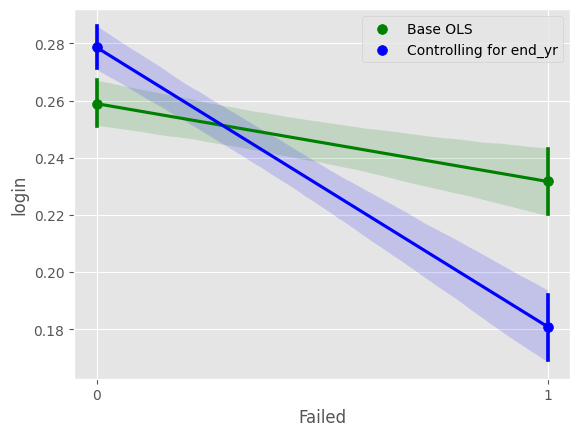

In [69]:
plot_freg('login', data=data, control='end_yr', save='login_basic.png')

**Control for industry _and_ end year**

In [99]:
run_model('login', control=['end_yr', 'new_industrygroup']).summary();

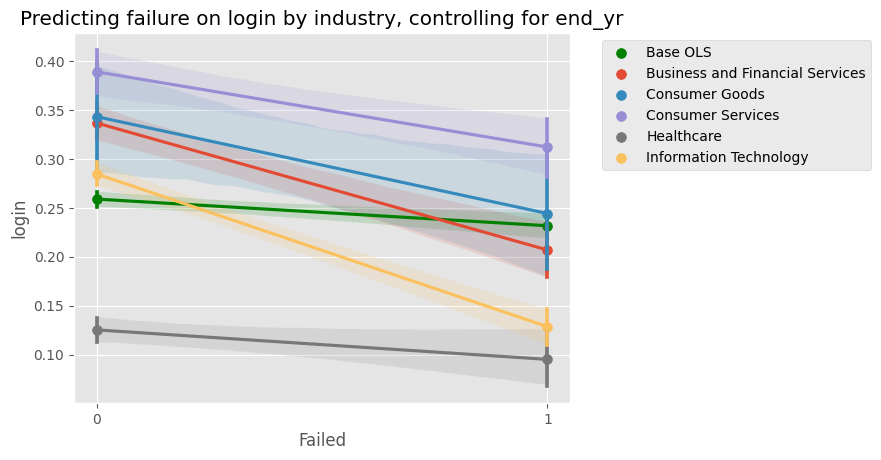

In [100]:
plot_freg('login', data=data, control='end_yr', industry=True)

## Does final screenshot include a careers page?

In [103]:
run_model('careers').summary();

**Controlling for end year**

In [104]:
run_model('careers', control=['end_yr']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     818.5
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:23:23   Log-Likelihood:                -3305.6
No. Observations:               16795   AIC:                             6667.
Df Residuals:                   16767   BIC:                             6884.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0198      0.132      0.150      0.881      -0.239       0.278
careers          -0.0989      0.005    -20.418      0.000      -0.108      -0.089
end_yr_1998.0    -0.0042      0.148     -0.028      0.978      -0.295       0.286
end_yr_1999.0    -0.0065      0.134     -0.049      0.961      -0.270       0.256
end_yr_2000.0    -0.0060      0.133     -0.045      0.964      -0.267       0.255
end_yr_2001.0     0.0016      0.133      0.012      0.991      -0.260       0.263
end_yr_2002.0    -0.0034      0.133     -0.026      0.979      -0.265       0.258
end_yr_2003.0    -0.0036      0.133     -0.027      0.979      -0.265       0.258
end_yr_2004.0    -0.0060      0.133     -0.045      0.964      -0.267       0.255
end_yr_2005.0     0.0103      0.133      0.077      0.938      -0.251       0.271
end_yr_2006.0     0.0157      0.133      0.118      0.906      -0.245       0.276
end_yr_2007.0     0.0280      0.133      0.211      0.833      -0.232       0.288
end_yr_2008.0     0.0419      0.133      0.315      0.753      -0.219       0.303
end_yr_2009.0     0.0272      0.133      0.205      0.838      -0.233       0.288
end_yr_2010.0     0.0397      0.133      0.299      0.765      -0.220       0.299
end_yr_2011.0     0.0418      0.132      0.315      0.753      -0.218       0.301
end_yr_2012.0     0.0435      0.132      0.328      0.743      -0.216       0.303
end_yr_2013.0     0.0468      0.132      0.353      0.724      -0.213       0.306
end_yr_2014.0     0.0486      0.132      0.367      0.714      -0.211       0.308
end_yr_2015.0     0.0476      0.132      0.359      0.719      -0.212       0.307
end_yr_2016.0     0.0545      0.132      0.411      0.681      -0.205       0.314
end_yr_2017.0     0.0517      0.132      0.391      0.696      -0.208       0.311
end_yr_2018.0     0.0405      0.132      0.306      0.760      -0.219       0.300
end_yr_2019.0     0.0519      0.132      0.392      0.695      -0.207       0.311
end_yr_2020.0     0.1001      0.139      0.719      0.472      -0.173       0.373
end_yr_2021.0     0.0581      0.133      0.436      0.662      -0.203       0.319
end_yr_2022.0     0.0593      0.133      0.446      0.656      -0.201       0.320
end_yr_2023.0     0.7031      0.132      5.330      0.000       0.444       0.962
==============================================================================
Omnibus:                     2694.463   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4283.705
Skew:                          -1.116   Prob(JB):                         0.00
Kurtosis:                       4.067   Cond. No.                         366.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

**Plot**

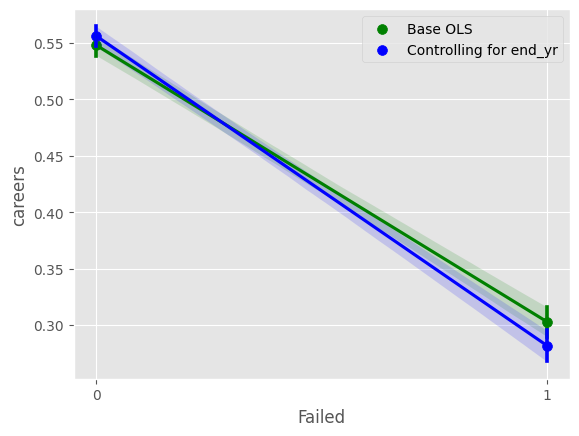

In [39]:
plot_freg('careers', data, 'end_yr')

**Plot for industry**

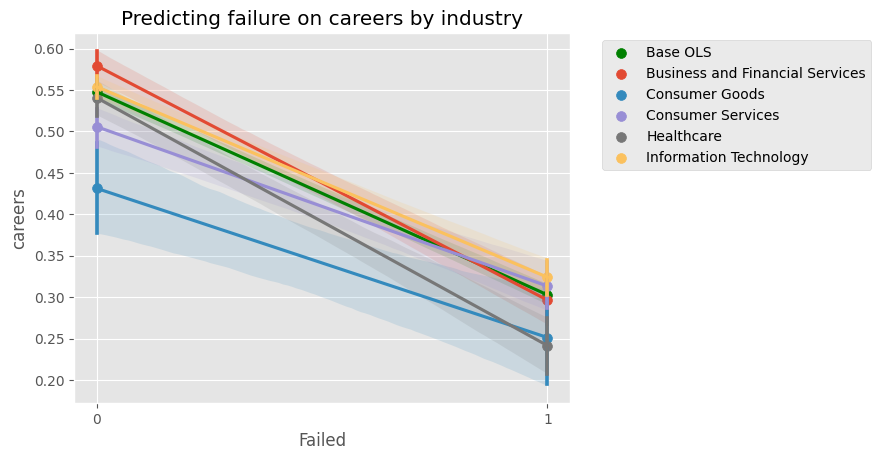

In [46]:
plot_freg('careers', data, industry=True)

**Plot for industry, controlling for end year**

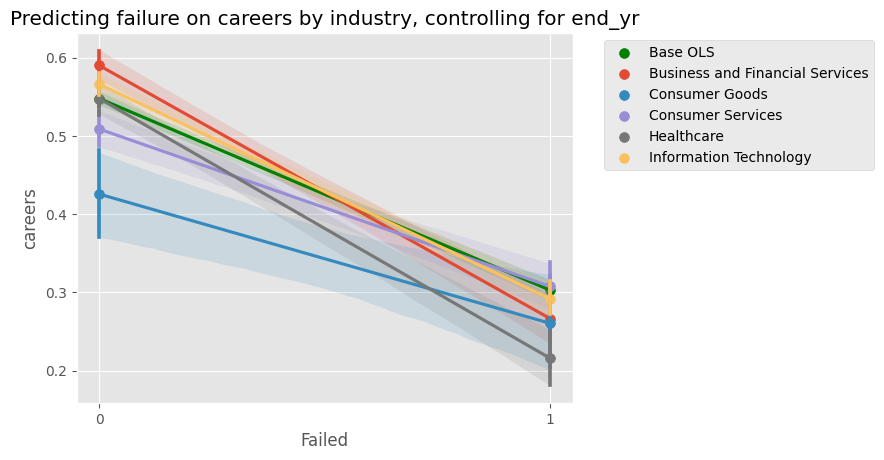

In [48]:
plot_freg('careers', data, control='end_yr', industry=True)

## What's the size of the final screenshot?

Setup

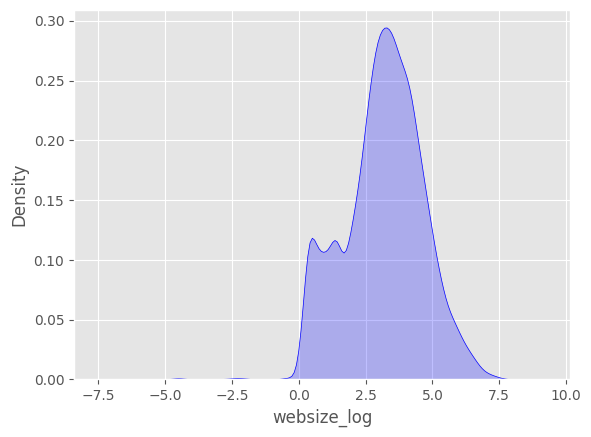

In [49]:
# Check out distribution
sns.kdeplot(data['websize_log'], color='b', fill='b');

**OLS Regression**

In [110]:
run_model('websize_log').summary();

**Control for year**

In [114]:
run_model('websize_log', control=['capture_yr']).summary();

**Control for industry**

In [116]:
run_model('websize_log', control=['new_industrygroup']).pvalues

const                                                0.000000e+00
websize_log                                         1.749552e-165
new_industrygroup_Consumer Goods                     1.928606e-15
new_industrygroup_Consumer Services                  1.667128e-14
new_industrygroup_Energy and Utilities               2.579620e-03
new_industrygroup_Healthcare                         5.774832e-07
new_industrygroup_Industrial Goods and Materials     1.294903e-03
new_industrygroup_Information Technology             7.671302e-01
new_industrygroup_To Be Assigned                     1.074850e-01
dtype: float64

**Plot, controlling for end year**

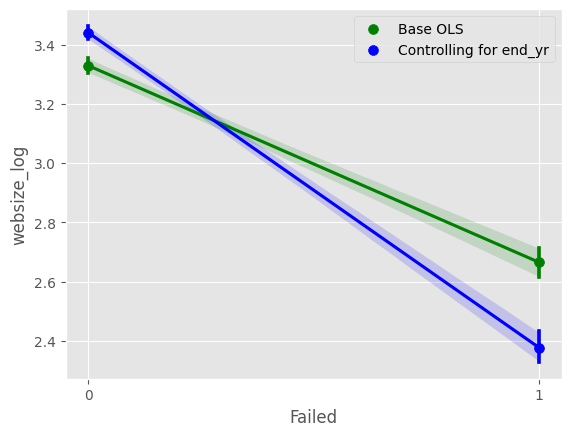

In [67]:
plot_freg('websize_log', data, control='end_yr')

**Industry Plot**

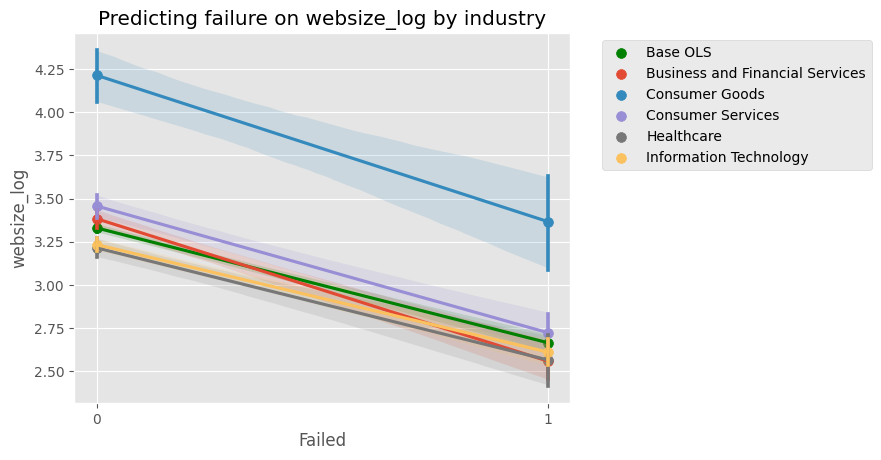

In [60]:
plot_freg('websize_log', data, industry=True)

**Plot for industry, controlling for capture year**

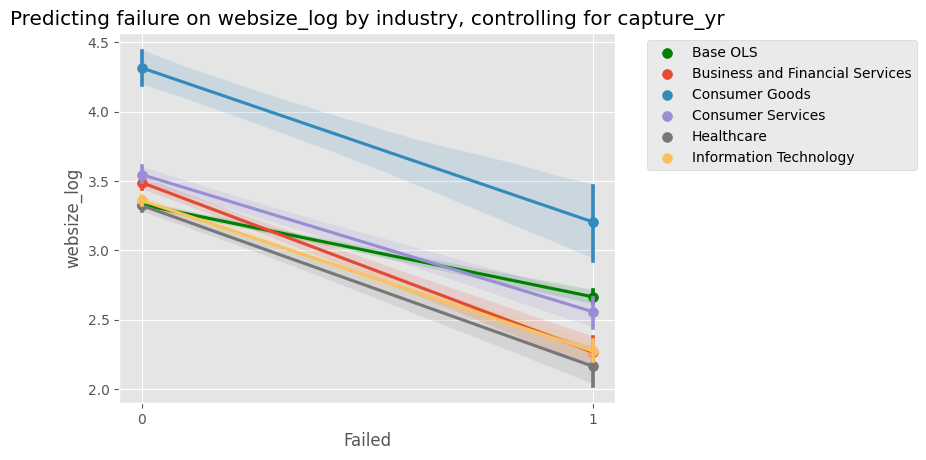

In [70]:
plot_freg('websize_log', data, control='capture_yr', industry=True, save='websize_log_ind_ey.png')